In [1]:
#ignore this
%load_ext music21.ipython21

# User's Guide, Chapter 16: TinyNotation

So far in this User's Guide, we've been loading music into `music21` either with one of the `corpus.parse` or `converter.parse` methods, which is great if you already have a piece of music in the corpus or in a file somewhere, or by building up a score note by note using the `stream.Stream()` and `note.Note()` objects.

But suppose that you want to get some music into `music21` that is too long to use the `note.Note()` build up, but too short to be worth firing up your notation editor to make a file? As you might imagine, this was a problem that the `music21` design team encountered often during the early development stages of the system, and we created our own solution with a format called "TinyNotation".

As its name implies, TinyNotation is designed to be a simple and lightweight notation syntax for getting simple music into `music21` (and from there, into the larger world).  It borrows from earlier simple notation solutions, especially Lilypond's syntax (but also ABC Notation and Humdrum/Kern).  I also tried to learn from their growth compared to more structured notation systems, such as MusicXML.  What I discovered is that the simpler a system is at inputting simple notes, the more complex that format is when dealing with really complex music. It's a major problem with simple solutions.

TinyNotation tries to avoid this limitation by, I'm serious here, making more complex notation impossible!  Parsing TinyNotation should always be easy to do, because it is intentionally extremely limited.  However, as we will demonstrate below, we designed TinyNotation so it would be easy to subclass into NotSoTinyNotation dialects that will, we hope, make _your_ particular notational needs possible (and pretty simple).  Let's begin with the basics, and we'll start with examples.

Here's a bunch of quarter notes in 4/4:

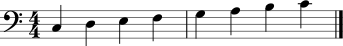

In [2]:
s = converter.parse('tinyNotation: 4/4 C4 D4 E4 F4 G4 A4 B4 c4')
s.show()

Notice that the last "c" is lowercase, while the rest of the notes are uppercase.  Case determines octave: "C" = the c in bass clef (C3) while "c" = middle C (C4).  Here are some other octaves:

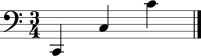

In [3]:
s = converter.parse("tinyNotation: 3/4 CC4 C4 c4")
s.show()

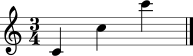

In [4]:
s = converter.parse("tinyNotation: 3/4 c4 c'4 c''4")
s.show()

And, yes, CCC is the C below CC, and c''' is the c above c''.  Remember when you use higher notes to make sure to enclose your string in double quotes, not single quotes.

Typing all those "4"s for each of the quarter notes got tedious, so if the number for a duration is omitted, then the next note uses the previous note's duration:

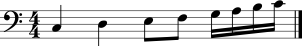

In [5]:
s = converter.parse('tinyNotation: 4/4 C4 D E8 F G16 A B c')
s.show()

Periods signify dots, "r" is for a rest, and "~" indicates a tie:

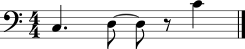

In [6]:
s = converter.parse('tinyNotation: 4/4 C.4 D8~ D8 r c4')
s.show()

Sharps, flats, and, if needed, naturals are indicated with `#`, `-` (not `b`) and, `n`, respectively:

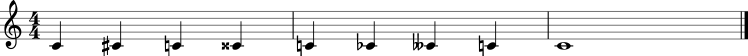

In [7]:
s = converter.parse('tinyNotation: 4/4 c4 c# c c## cn c- c-- c c1')
s.show()

And, finally, triplets are possible by enclosing the triplet notes in curly brackets along with a special `trip` prefix:

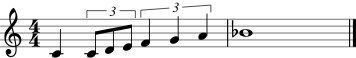

In [8]:
s = converter.parse('tinyNotation: 4/4 c4 trip{c8 d e} trip{f4 g a} b-1')
s.show()

Okay -- so what if you want to do something more complex?  Apply an id to a note with the "=" tag, and then make changes to it using music21:

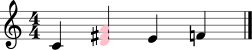

In [9]:
s = converter.parse('tinyNotation: 4/4 c4 d=id2 e f')
n = s.recurse().getElementById('id2')
ch = chord.Chord('D4 F#4 A4')
ch.color = 'pink'
n.activeSite.replace(n, ch)
s.show()